# Lineages
Natalia Vélez, July 2020

In this notebook:

* Charting lineages
* Comparing lineages using various measures of well-being (# descendants, lifespan, causes of death, etc.)
* Preparing inputs for subsequent analyses (combined with food, map change logs)

This notebook uses data from November 2019--June 2020 (which corresponds to the Boundless World era)

In [39]:
%matplotlib inline

import os, re, glob
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

from os.path import join as opj
from tqdm import notebook
from ast import literal_eval as make_tuple

sns.set_context('talk')
sns.set_style('white')

def gsearch(*args): return glob.glob(opj(*args))

Get data from all eras:

In [2]:
era_files = glob.glob('outputs/lifelogs*_data.tsv')
births_list = []

for f in era_files:
    era_data = pd.read_csv(f, sep='\t', index_col=0)
    births_list.append(era_data)

/Users/nvelez/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Dataframe of births:

In [3]:
births = pd.concat(births_list)

## Clelan up  data
birth_cols = ['server', 'release', 'era', 'timestamp', 'playerID', 
              'hash', 'sex', 'location', 'parent', 'pop','chain']

# Dataframe of births
births = births[births['event'] == 'B'].reset_index(drop=True)
births = births[birth_cols]

# Parse player IDs
births['playerID'] = births['playerID'].astype(np.int)

# Parse parent IDs
births['parent'] = births['parent'].str.extract('(noParent|(?<=parent=)[0-9]+)')
births['parent'] = births['parent'].str.replace('noParent', '-1')
births['parent'] = births['parent'].astype(np.int)

# Order from most recent
births = births.sort_values('timestamp', ascending=False)
births.head()

,server,release,era,timestamp,playerID,hash,sex,location,parent,pop,chain
776124,bigserver2,342.0,boundless,1592294385,3080254,39296c04b20e5b46ace3469c4f45d3a0f06c2147,M,"(-454358,53)",3080205,29,16.0
776125,bigserver2,342.0,boundless,1592294385,3080255,fe3d99761b4b62f37e50d74f720d97ecc9fb0029,M,"(-454358,53)",3080205,30,16.0
776123,bigserver2,342.0,boundless,1592294343,3080253,a8b5975a81344f690f45ffc2554a0bc35af557a9,M,"(-454363,94)",3080205,29,16.0
776122,bigserver2,342.0,boundless,1592294341,3080252,b2d09ba08ab6c9880104599a8bbfd91d9fa8e70d,F,"(-454829,-124)",3080235,29,2.0
776121,bigserver2,342.0,boundless,1592294331,3080251,0bd1a9d5200e6d6af7e8d808f79dc93496637987,M,"(-454400,-1)",3080228,29,17.0


## Sanity check: How many lineages can we expect?

Spot eves:

In [5]:
eves = births[births['parent'] < 0]
print(eves['playerID'][:10])

776119    3080249
776105    3080235
776079    3080209
776078    3080208
776074    3080204
776072    3080202
776038    3080166
775945    3080067
775922    3080044
775908    3080029
Name: playerID, dtype: int64


How many Eves?

In [6]:
n_eves = len(eves)
n_births = len(births)
eve_rate = n_eves/n_births
print('%i Eves out of %i births (%0.2f%%)' % (n_eves, n_births, eve_rate*100))

170126 Eves out of 2934434 births (5.80%)


Eve spawn rate over time:

[Text(0, 0.5, 'Eve spawn rate'), Text(0.5, 0, 'Release #')]

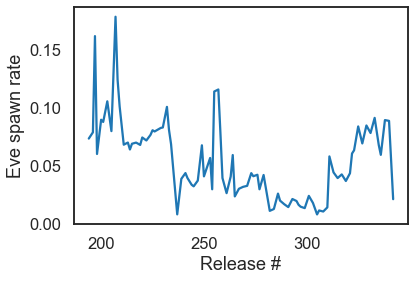

In [8]:
eve_rate = births.copy()
eve_rate['is_eve'] = eve_rate['parent'] < 0
eve_rate = eve_rate.groupby('release')['is_eve'].agg(['count', 'sum']).reset_index()
eve_rate = eve_rate.rename(columns={'count': 'n_births', 'sum': 'n_eves'})
eve_rate['eve_rate'] = eve_rate['n_eves']/eve_rate['n_births']

ax = sns.lineplot('release', 'eve_rate', data=eve_rate)
ax.set(xlabel = 'Release #', ylabel = 'Eve spawn rate')

## Parse names

Helper function: Remove from data...

* Roman numerals (including some nonsense ones at high-gen numbers)
* Kin labels? (e.g., SHINA1580640)

In [9]:
def is_roman(s):
    # Checks if string is a "valid" Roman numeral
    # Note this includes some *cough*idiosyncratic*cough* numerals in the OHOL dataset:
    # e.g., CLXLIII => True (but actually nonsense)
    roman_regex  = 'M{0,4}(CM|CD|D?C{0,3})(LXL|XC|XL|L?X{0,3})(IX|IV|V?I{0,3})'
    roman_match = re.match(roman_regex, s)
    
    str_length = len(s)
    match_length = roman_match.span()[1]
    
    return str_length == match_length

def is_kin(s, idx):
    kin_regex = '[A-Z]{0,}[0-9]+'
    kin_match = re.search(kin_regex, s)
    return bool(kin_match) & (idx > 0)

def is_valid(s, idx):
    
    not_roman = not is_roman(s)
    not_kin = not is_kin(s, idx)
    
    return not_roman & not_kin

Find name files:

In [10]:
data_dir = '../data'
name_files = glob.glob(opj(data_dir, 'publicLifeLogData', 'lifeLog_bigserver2*', '*names.txt'))
name_files.sort()
print(*[os.path.basename(f) for f in name_files[:5]], sep='\n')

2019_01January_29_Tuesday_names.txt
2019_01January_30_Wednesday_names.txt
2019_01January_31_Thursday_names.txt
2019_02February_01_Friday_names.txt
2019_02February_02_Saturday_names.txt


Iterate over name files and extract names:

In [11]:
name_list = []
re.compile("^([A-Z][0-9]+)+$")

for f in notebook.tqdm(name_files):
    with open(f, 'r') as handle:
        data_str = handle.read().splitlines()

    data = []
    for s in data_str:
        row_data = s.split() # Split lines
        row_data = [si for idx, si in enumerate(row_data) if is_valid(si, idx)]
        
        if len(row_data) > 3:
            row_data.remove('EVE')
            print('Corrected: %s' % row_data)

        while len(row_data) < 3: 
            row_data.append('')

        name_list.append(row_data)

Corrected: ['386865', 'MOON', 'ROA']
Corrected: ['388702', 'MARTHA', 'LIGHT']
Corrected: ['1240637', 'ALEX', 'CHAN']
Corrected: ['1577563', 'KNIGHT', 'FIERRO']
Corrected: ['1579101', 'LARIAH', 'HANNAM']
Corrected: ['1579766', 'JACKIE', 'WISCOMBE']
Corrected: ['1580507', 'BENJAMIN', 'GIOVANNI']



Assemble into dataframe:

In [12]:
name_df = pd.DataFrame(name_list, columns=['playerID', 'first', 'last'])
name_df['playerID'] = name_df['playerID'].astype(np.int)
name_df.head()

,playerID,first,last
0,5,EVE,ARK
1,4,SLY,
2,6,FOX,ARK
3,9,EVE,ISA
4,10,TESIA,ISA


Merge with `births`:

In [13]:
birth_df = pd.merge(births, name_df, on='playerID')
birth_df.head()

,server,release,era,timestamp,playerID,hash,sex,location,parent,pop,chain,first,last
0,bigserver2,342.0,boundless,1592288229,3080130,2cdc4d0b016f9c0d96d27013f1d19c42596e0c5c,F,"(-454640,41)",3080111,30,4.0,CLAUDINE,P
1,bigserver2,342.0,boundless,1592288191,3080128,a8b5975a81344f690f45ffc2554a0bc35af557a9,F,"(-454394,-4)",3080105,29,13.0,DACY,LIGHTNING
2,bigserver2,342.0,boundless,1592288138,3080125,c5838da39fd525a2ac24aee049dae6a42e502236,F,"(-311131,-322)",3080101,29,53.0,SHOKO,GREATHOUSE
3,bigserver2,342.0,boundless,1592288029,3080122,11f9fce50bbc1ebbba5126434aea123e79249942,M,"(-454638,41)",3080104,30,4.0,RANGER,PICKLE
4,bigserver2,342.0,boundless,1592287917,3080120,b265b1958566b474094cf0282a0fa59e6d622885,F,"(-311111,-311)",3080101,33,53.0,HAPPY,GREATHOUSE


## Build family trees

Search thru boundless families:

In [16]:
boundless_df = births[births['era'] == 'boundless'].reset_index(drop=True)

Iterate over parent-child links:

In [24]:
all_families = nx.DiGraph()
n_rows = len(birth_df)

for idx, row in notebook.tqdm(birth_df.iterrows(), total=n_rows):
        # Link mom to child
        mom = row['parent']
        child = row['playerID']
        
        if mom > 0:
            all_families.add_edge(mom, child)

Split into subgraphs:

In [35]:
families = [all_families.subgraph(c).copy() for c in nx.weakly_connected_components(all_families)]

Plot families:

In [ ]:
nx.draw(families[0])
pos=graphviz_layout(families[0], prog='dot')


ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

In [36]:
len(families)

45161

In [ ]:
nx.weakly_connected_components